<a href="https://colab.research.google.com/github/TBSantana/capstoneProjectUB/blob/main/XGBoost_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install scikit-optimize

In [ ]:
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from skopt import gp_minimize

In [ ]:
cols = ['year', 'month', 'CasosCovMes', 'CasosCovMesAnt',  'availability_30', 'availability_60']
data = pd.read_csv('listings_transformed.csv.gz', usecols=cols)

df = data.groupby(['year', 'month'], as_index=False).mean()
df = df[['year', 'CasosCovMesAnt', 'CasosCovMes', 'availability_30', 'month', 'availability_60']]

df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df = df.drop(columns=['month'])

train = df.iloc[:25]
val = df.iloc[25:]

print('Train shape:', train.shape)
print('Val shape:', val.shape)

Train shape: (25, 7)
Val shape: (3, 7)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scalerY = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(train)
scalerY.fit(train['availability_60'].values.reshape(-1, 1));

In [ ]:
def prep_seqs(df, scalerX, scalerY, l=3, h=3):
    X = []
    Y = []
    for i in range(l, df.shape[0]-h):
        f = df.iloc[i-l:i]
        y = df.iloc[i:i+h]['availability_60'] 

        X.append(scalerX.transform(f))
        Y.append(scalerY.transform(y.values.reshape(-1, 1)))

    X = np.array(X)
    Y = np.array(Y)

    X = np.swapaxes(X, 0, 1)
    
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float().squeeze()

In [ ]:
X, Y = prep_seqs(train, scaler, scalerY)

xval = df.iloc[-6:-3]
Xt = scaler.transform(xval.values)
Xt = np.expand_dims(Xt, axis=1)
Xt = torch.from_numpy(Xt).float()

yval = df.iloc[-3:]['availability_60']
Yt = scalerY.transform(yval.values.reshape(-1, 1))
Yt = torch.from_numpy(Yt).float().squeeze()

X = X.cuda()
Y = Y.cuda()

Xt = Xt.cuda()

print('X shape: {} and Y shape: {}'.format(X.shape, Y.shape))
print('Xt shape: {} and Yt shape: {}'.format(Xt.shape, Yt.shape))
# X shape is (steps, samples, features)

X shape: torch.Size([3, 15, 7]) and Y shape: torch.Size([15, 3])
Xt shape: torch.Size([3, 1, 7]) and Yt shape: torch.Size([3])


In [ ]:
class LSTMRNN(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(LSTMRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, 3)
        
    def forward(self, input):
        output, _ = self.lstm(input)
        output = output[-1, :, :]
        output = self.out(output) 
        return output    

In [ ]:
%%time
n_seeds = 10
total_p = np.zeros((Yt.shape[0], 1, n_seeds))

for seed in range(n_seeds):
  torch.manual_seed(seed)
  np.random.seed(seed)

  lstm = LSTMRNN(100, X.shape[-1]).cuda()

  criterion = nn.L1Loss()
  lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

  for i in range(10):
      lstm.zero_grad()
      
      o = lstm(X)
      loss = criterion(o, Y)
      loss.backward()
      lstm_optimizer.step()
      
      p = lstm(Xt)
      p = p.detach().cpu()
  
  y_real = scalerY.inverse_transform(Yt.numpy().reshape(-1, 1))
  y_hat = scalerY.inverse_transform(p.numpy().reshape(-1, 1))
  error = mean_absolute_error(y_real, y_hat)
  total_p[:, :, seed] = error

  print('Seed {} - Error: {:.3f}'.format(seed, error))

avg_seed_error = total_p.mean(axis=-1)

print('\nEnsemble Avg Score = {:.3f}\n'.format(avg_seed_error[0][0]))

Seed 0 - Error: 1.712
Seed 1 - Error: 2.655
Seed 2 - Error: 2.870
Seed 3 - Error: 2.225
Seed 4 - Error: 2.908
Seed 5 - Error: 1.822
Seed 6 - Error: 1.916
Seed 7 - Error: 2.918
Seed 8 - Error: 1.373
Seed 9 - Error: 1.141

Ensemble Avg Score = 2.154

CPU times: user 247 ms, sys: 12.8 ms, total: 260 ms
Wall time: 450 ms


In [ ]:
ndf = pd.DataFrame({'y_real': y_real[:,0], 'y_hat': y_hat[:,0]}, index=np.arange(y_hat.shape[0]))
ndf

,y_real,y_hat
0,37.524391,35.998192
1,36.568878,35.278206
2,34.651894,34.046238


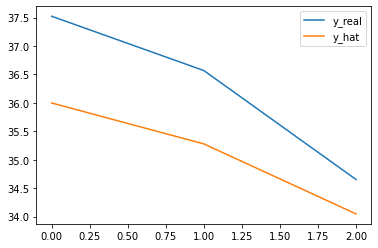

In [ ]:
ndf.plot();

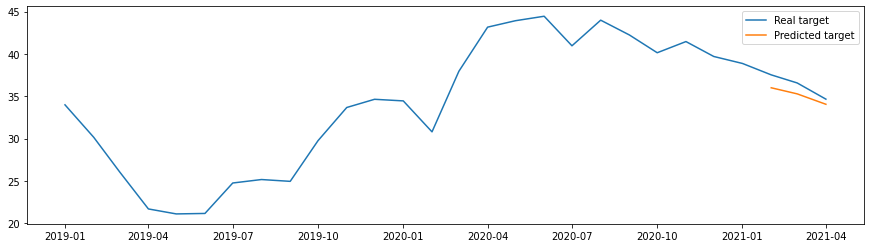

In [ ]:
df = data.groupby(['year', 'month'], as_index=False).mean()
df['date'] = df.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

f, ax = plt.subplots(figsize=(15, 4))
ax.plot(df.date.values, df.availability_60.values, label='Real target')
ax.plot(df.date.values[-3:], y_hat[:, 0], label='Predicted target')
ax.legend();

In [ ]:
%%time

def run_rnn(params):

  hidden_size, learning_rate = params

  n_seeds = 10
  total_p = np.zeros((Yt.shape[0], 1, n_seeds))

  for seed in range(n_seeds):
    torch.manual_seed(seed)
    np.random.seed(seed)

    lstm = LSTMRNN(hidden_size, X.shape[-1]).cuda()

    criterion = nn.L1Loss()
    lstm_optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

    for i in range(10):
        lstm.zero_grad()
        
        o = lstm(X)
        loss = criterion(o, Y)
        loss.backward()
        lstm_optimizer.step()
        
        p = lstm(Xt)
        p = p.detach().cpu()
    
    y_real = scalerY.inverse_transform(Yt.numpy().reshape(-1, 1))
    y_hat = scalerY.inverse_transform(p.numpy().reshape(-1, 1))
    error = mean_absolute_error(y_real, y_hat)
    total_p[:, :, seed] = error

  avg_seed_error = total_p.mean(axis=-1)
  return avg_seed_error[0][0]  

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
space = [(10, 200),                       # hidden_size 
         (1e-5, 1e-1, 'log-uniform')]     # learning_rate

res = gp_minimize(run_rnn, space, random_state=0, n_calls=50)

hidden_size, learning_rate = res.x
min_avg_error = res.fun

print('Best parameters: \n\thidden_size = {}\n\tlearning_rate = {}\n\nMinimum avg error = {}'.format(hidden_size, learning_rate, min_avg_error))

Best parameters: 
	hidden_size = 165
	learning_rate = 0.001051717233627859

Minimum avg error = 0.7679637730121612


In [ ]:
%%time
n_seeds = 10
total_p = np.zeros((Yt.shape[0], 1, n_seeds))

for seed in range(n_seeds):
  torch.manual_seed(seed)
  np.random.seed(seed)

  lstm = LSTMRNN(hidden_size, X.shape[-1]).cuda()

  criterion = nn.L1Loss()
  lstm_optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

  for i in range(10):
      lstm.zero_grad()
      
      o = lstm(X)
      loss = criterion(o, Y)
      loss.backward()
      lstm_optimizer.step()
      
      p = lstm(Xt)
      p = p.detach().cpu()
  
  y_real = scalerY.inverse_transform(Yt.numpy().reshape(-1, 1))
  new_y_hat = scalerY.inverse_transform(p.numpy().reshape(-1, 1))
  error = mean_absolute_error(y_real, new_y_hat)
  total_p[:, :, seed] = error

  print('Seed {} - Error: {:.3f}'.format(seed, error))

avg_seed_error = total_p.mean(axis=-1)
#avg_error = mean_absolute_error(y_real, avg_seed_error)

print('\nEnsemble Avg Score = {:.3f}\n'.format(avg_seed_error[0][0]))

Seed 0 - Error: 0.443
Seed 1 - Error: 0.635
Seed 2 - Error: 0.526
Seed 3 - Error: 0.844
Seed 4 - Error: 1.194
Seed 5 - Error: 1.105
Seed 6 - Error: 0.625
Seed 7 - Error: 1.009
Seed 8 - Error: 0.987
Seed 9 - Error: 0.312

Ensemble Avg Score = 0.768

CPU times: user 234 ms, sys: 10.4 ms, total: 244 ms
Wall time: 244 ms


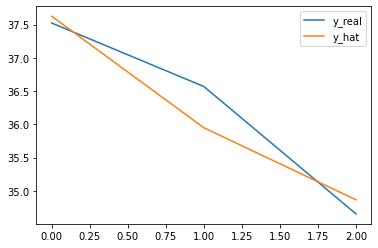

In [ ]:
ndf_tuned = pd.DataFrame({'y_real': y_real[:,0], 'y_hat': new_y_hat[:,0]}, index=np.arange(y_hat.shape[0]))
ndf_tuned.plot()

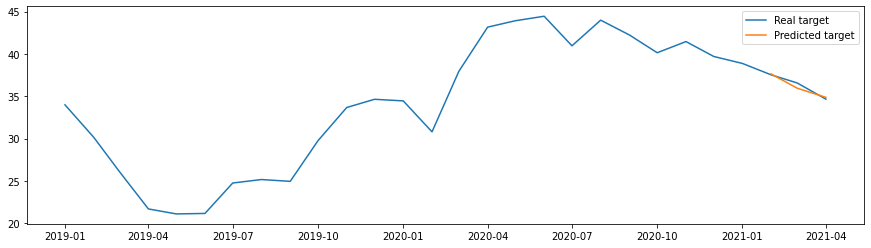

In [ ]:
df = data.groupby(['year', 'month'], as_index=False).mean()
df['date'] = df.apply(lambda x: datetime(int(x.year), int(x.month), 1), axis=1)

f, ax = plt.subplots(figsize=(15, 4))
ax.plot(df.date.values, df.availability_60.values, label='Real target')
ax.plot(df.date.values[-3:], new_y_hat[:, 0], label='Predicted target')
ax.legend();